In [177]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import copy
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Dense, Lambda, Input, Subtract
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
movie = pd.read_csv('/content/drive/MyDrive/Objective 3/Dataset/Movies_Dataset/ML 1M/movies.csv',encoding="ISO-8859-1")
rating = pd.read_csv('/content/drive/MyDrive/Objective 3/Dataset/Movies_Dataset/ML 1M/ratings.csv',encoding="ISO-8859-1")
user = pd.read_csv('/content/drive/MyDrive/Objective 3/Dataset/Movies_Dataset/ML 1M/users.csv',encoding="ISO-8859-1")

In [180]:
user.head(1)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067


In [181]:
rating.head(1)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760


In [182]:
ML = movie.merge(rating, how= 'outer', on='MovieID')

In [183]:
ML1M = ML.merge(user, how= 'outer', on='UserID')

In [184]:
ML1M.head(1)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story,Animation|Children's|Comedy,1.0,5.0,978824268.0,F,1.0,10.0,48067


In [185]:
ML1M['Genres'] = pd.Series(ML1M['Genres'], dtype="string")
ML1M['Genres'].astype(str)
ML1M['Genres'] = ML1M['Genres'].fillna(' ')
ML1M['Genres_list'] = ML1M['Genres'].str.split('|')

In [186]:
from sklearn.preprocessing import MultiLabelBinarizer
list2series = pd.Series(ML1M.Genres_list)
mlb = MultiLabelBinarizer()

In [187]:
one_hot_genres = pd.DataFrame(mlb.fit_transform(list2series), columns=mlb.classes_, index=ML1M['MovieID'])
one_hot_genres.head()

,,Miami Beach (1988),Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
150,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
260,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
527,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [188]:
one_hot_genres.reset_index(drop=True, inplace=True)

In [189]:
one_hot_genres.shape

(1000386, 20)

In [190]:
start_column = 0  # index 2 corresponds to 'col3'
end_column = 21   # index 5 corresponds to 'col5'

# Calculate the average across the specified range of columns
ML1M['score_genre'] = one_hot_genres.iloc[:, start_column:end_column + 1].mean(axis=1)

In [191]:
ML1M.head(1)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Genres_list,score_genre
0,1,Toy Story,Animation|Children's|Comedy,1.0,5.0,978824268.0,F,1.0,10.0,48067,"[Animation, Children's, Comedy]",0.15


In [192]:
ML1M['gender_score'] = ML1M['Gender'].replace({'M': 0, 'F': 1})

In [193]:
ML1M['Occupation_score'] = (ML1M['Occupation']-ML1M['Occupation'].min())/(ML1M['Occupation'].max()-ML1M['Occupation'].min())
ML1M['Age_score'] = (ML1M['Age']-ML1M['Age'].min())/(ML1M['Age'].max()-ML1M['Age'].min())
ML1M['rating'] = (ML1M['Rating']-ML1M['Rating'].min())/(ML1M['Rating'].max()-ML1M['Rating'].min())

In [194]:
#ML1M['user_embedding']  = ML1M.apply(lambda x: list([x['Occupation_score'],
                                        #x['score_genre']]),axis=1)

In [195]:
ML1M.head(1)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Genres_list,score_genre,gender_score,Occupation_score,Age_score,rating
0,1,Toy Story,Animation|Children's|Comedy,1.0,5.0,978824268.0,F,1.0,10.0,48067,"[Animation, Children's, Comedy]",0.15,1.0,0.5,0.0,1.0


In [196]:
MovieLens1M = ML1M[['MovieID', 'UserID','rating','score_genre',	'gender_score','Occupation_score','Age_score']].copy()

In [197]:
MovieLens1M.head(1)

,MovieID,UserID,rating,score_genre,gender_score,Occupation_score,Age_score
0,1,1.0,1.0,0.15,1.0,0.5,0.0


In [198]:
matrix = ML1M.pivot_table(columns = 'MovieID',index ='UserID', values ='rating')

In [199]:
matrix.fillna(0,inplace=True)

In [200]:
matrix

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.00,0.0,0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036.0,0.0,0.0,0.0,0.25,0.0,0.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
matrix = np.array(matrix)

In [202]:
total_elements = matrix.size
zero_elements = np.count_nonzero(matrix == 0)
sparsity_percentage = (zero_elements / total_elements) * 100
print("Sparsity Percentage:", sparsity_percentage)

Sparsity Percentage: 95.78259078708949


In [203]:
from sklearn.metrics.pairwise import cosine_similarity
movie_cosine = cosine_similarity(matrix.T)
user_cosine = cosine_similarity(matrix)
user_cosine.shape , movie_cosine.shape

((6040, 6040), (3706, 3706))

In [204]:
from scipy.sparse.linalg import svds
#m sklearn.utils.extmath import svd_uv

In [205]:
from scipy.sparse.linalg import svds
user_svd, sigma, movie_svd = svds(matrix, k = 100)
user_svd.shape, movie_svd.shape

((6040, 100), (100, 3706))

In [206]:
matrix

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.5, 0. , 0. , ..., 0. , 0. , 0. ]])

In [207]:
user_svd, sigma, movie_svd = svds(matrix, k = 100)

In [208]:
user_svd.shape, movie_svd.shape

((6040, 100), (100, 3706))

In [209]:
def mlp_train_and_test(data_trn, u_embed, s_embed, u_cosine, m_cosine):
    X = []
    y = []

    print(data_trn.shape)

    for i in range(data_trn.shape[0]):
        for j in range(data_trn.shape[1]):
            if data_trn[i][j]!=0:
                X.append(np.concatenate((u_embed[i], s_embed[j], u_cosine[i], m_cosine[j]), axis=None))
                y.append(data_trn[i][j])

    X_train = np.array(X)
    y_train = np.array(y)

    print(X_train.shape)

    np.random.seed(0)

    mlp_model = keras.Sequential()
    mlp_model.add(Dense(200, activation='relu', kernel_initializer='random_normal', input_shape=(X_train.shape[1],)))
    mlp_model.add(Dropout(0.4))
    mlp_model.add(Dense(50, activation='relu', kernel_initializer='random_normal'))
    mlp_model.add(Dropout(0.1))
    mlp_model.add(Dense(1, activation='linear'))

    # summarize the model
    mlp_model.summary()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    #callback = [checkpoint, es]

    mlp_model.compile(optimizer='Adam(lr=0.001)', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]) #loss='mse'
    history = mlp_model.fit(X_train, y_train, epochs = 500, verbose=1, callbacks=[es], validation_split=0.20, shuffle=True)

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    z = []
    X_predict = []

    for i in range(data_trn.shape[0]):
        for j in range(data_trn.shape[1]):
            if data_trn[i][j] == 0.0:
                z.append((i, j, 0.0))

    for i, j, v in z:
        X_predict.append(np.concatenate((u_embed[i], s_embed[j], u_cosine[i], m_cosine[j]), axis= None))
    X_predict = np.array(X_predict)


    a = time.time()
    result = mlp_model.predict(X_predict)
    print("Prediction time:{:.8f}".format((time.time()-a)))

    data_pred = copy.deepcopy(data_trn)

    k = 0
    for i, j, v in z:
        data_pred[i][j] = result[k]
        k += 1
    return data_pred

In [210]:
ML1M.head(1)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Genres_list,score_genre,gender_score,Occupation_score,Age_score,rating
0,1,Toy Story,Animation|Children's|Comedy,1.0,5.0,978824268.0,F,1.0,10.0,48067,"[Animation, Children's, Comedy]",0.15,1.0,0.5,0.0,1.0


In [211]:
num_users = MovieLens1M['UserID'].nunique()
num_movies = MovieLens1M['MovieID'].nunique()

In [212]:
print(num_users), print(num_movies)

6040
3883


(None, None)

In [213]:
MovieLens1M.head(1)

,MovieID,UserID,rating,score_genre,gender_score,Occupation_score,Age_score
0,1,1.0,1.0,0.15,1.0,0.5,0.0


In [214]:
from sklearn.preprocessing import LabelEncoder
def encode_user_item(MovieLens1M, user_col, item_col,rating_col, Genre,Occupation,Age,gender):

    encoded_df = MovieLens1M.copy()

    user_encoder = LabelEncoder()
    user_encoder.fit(encoded_df[user_col].values)
    n_users = len(user_encoder.classes_)

    item_encoder = LabelEncoder()
    item_encoder.fit(encoded_df[item_col].values)
    n_items = len(item_encoder.classes_)

    encoded_df["USER"] = user_encoder.transform(encoded_df[user_col])
    encoded_df["ITEM"] = item_encoder.transform(encoded_df[item_col])

    encoded_df.rename({rating_col: ("Rating"), Genre: "score_genre", Occupation: "Occupation_score", Age: "Age_score", gender : "gender_score"}, axis=1, inplace=True)

    print("Number of users: ", num_users)
    print("Number of items: ", num_movies)

    return encoded_df, user_encoder, item_encoder

In [215]:
data, user_encoder, item_encoder = encode_user_item(MovieLens1M, "UserID", "MovieID", "rating", "score_genre",	"Occupation_score","Age_score","gender_score")

Number of users:  6040
Number of items:  3883


In [216]:
data.head(1)

,MovieID,UserID,Rating,score_genre,gender_score,Occupation_score,Age_score,USER,ITEM
0,1,1.0,1.0,0.15,1.0,0.5,0.0,0,0


In [217]:
data = data.fillna(0)

In [218]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense, Dropout
from keras.regularizers import l2
from keras.constraints import non_neg
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import model_to_dot
#from reco import vis

In [219]:
n_latent_factors_user = 10
n_latent_factors_movie = 10

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(num_movies +1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(num_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)

concat = keras.layers.concatenate([movie_vec, user_vec],axis = -1,name='Concat')
#concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
#dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
#dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
#dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
#dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_3)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [220]:
import os, time, sys, math
def create_directory(directory_path):
    current_path = os.getcwd()
    current_path
    new_dir_path= current_path + directory_path
    if os.path.exists(new_dir_path):
        print("Directory already exists %s" % new_dir_path)
    else:
        try:
            os.mkdir(new_dir_path)
        except OSError:
            print("Creation of the directory %s failed" % new_dir_path)
        else:
            print("Successfully created directory %s" % new_dir_path)

In [221]:
create_directory("/model-img")

Directory already exists /content/model-img


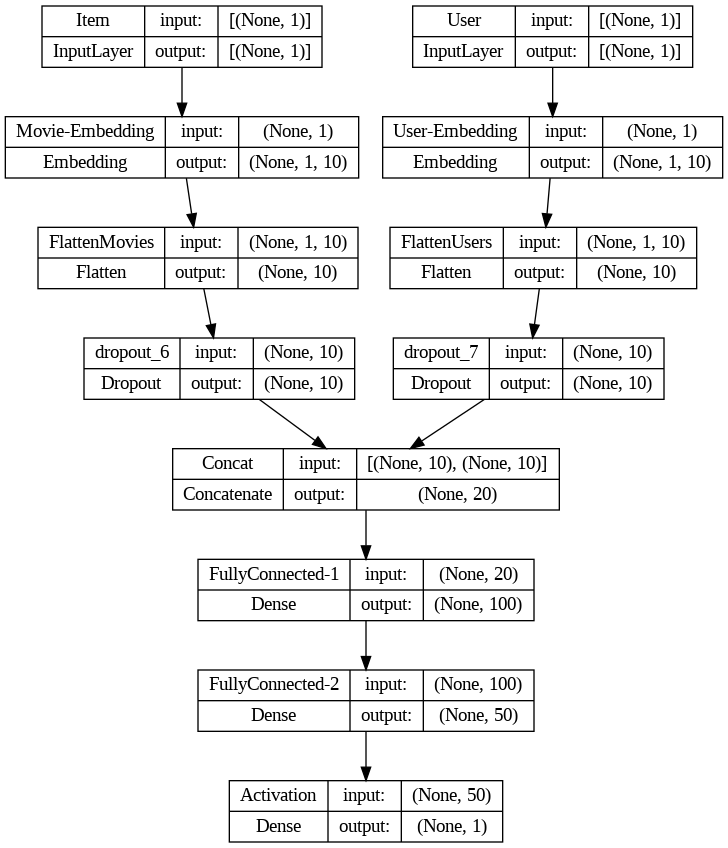

In [222]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/MFNN.png" )

In [223]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 10)                38840     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 10)                60410     ['User[0][0]']          

In [224]:
data.head(1)

,MovieID,UserID,Rating,score_genre,gender_score,Occupation_score,Age_score,USER,ITEM
0,1,1.0,1.0,0.15,1.0,0.5,0.0,0,0


In [225]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.1)
output = model.fit([train.USER, train.ITEM], train.Rating, batch_size= 128, epochs= 5, verbose=1, validation_split=0.1)

Epoch 1/5
6331/6331 [==============================] - 26s 4ms/step - loss: 0.1880 - rmse: 0.2404 - val_loss: 0.1815 - val_rmse: 0.2319
Epoch 2/5
6331/6331 [==============================] - 25s 4ms/step - loss: 0.1817 - rmse: 0.2332 - val_loss: 0.1805 - val_rmse: 0.2329
Epoch 3/5
6331/6331 [==============================] - 25s 4ms/step - loss: 0.1805 - rmse: 0.2322 - val_loss: 0.1797 - val_rmse: 0.2302
Epoch 4/5
6331/6331 [==============================] - 27s 4ms/step - loss: 0.1799 - rmse: 0.2316 - val_loss: 0.1794 - val_rmse: 0.2306
Epoch 5/5
6331/6331 [==============================] - 24s 4ms/step - loss: 0.1795 - rmse: 0.2312 - val_loss: 0.1791 - val_rmse: 0.2302


In [226]:
rmse_values = output.history['rmse']

In [227]:
RMSE = sum(rmse_values) / len(rmse_values)
print(RMSE)

0.23371771574020386
